<hr style="height:2px;">

# Demo: Denoising of 2D cell images

This notebook demonstrates training data generation for a 2D denoising task, where corresponding pairs of low and high quality images can be acquired.

The high SNR images are acquistions of Human U2OS cells taken from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/BBBC006/) and the low SNR images were created by synthetically adding *strong read-out and shot-noise* (and additionally applying *pixel binning* of 2x2) thus mimicking acquisitions at a very low light level.  

![](imgs/denoising_binning_overview.png)

Each image pair should be registered, which in a real application setting is best achieved by acquiring both images _interleaved_, i.e. as different channels that correspond to the different exposure/laser settings. 
Since the image pairs were synthetically created in this example, they are already perfectly aligned.

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, plot_some
from csbdeep.data import RawData, create_patches

<hr style="height:2px;">

# Example data

The example data consists of low-SNR and high-SNR 2D images of human U2OS cells.  
Note that `GT` stands for [ground truth](https://en.wikipedia.org/wiki/Ground_truth) and represents high signal-to-noise ratio (SNR) stacks.

In [3]:
download_and_extract_zip_file (
    url       = 'http://csbdeep.bioimagecomputing.com/example_data/snr_7_binning_2.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files missing, downloading... extracting... done.


The data set is already split into a **train** and **test** set, each containing low SNR ("low") and corresponding high SNR ("GT") images.

We can plot some training images:

image size = (2000, 2000)


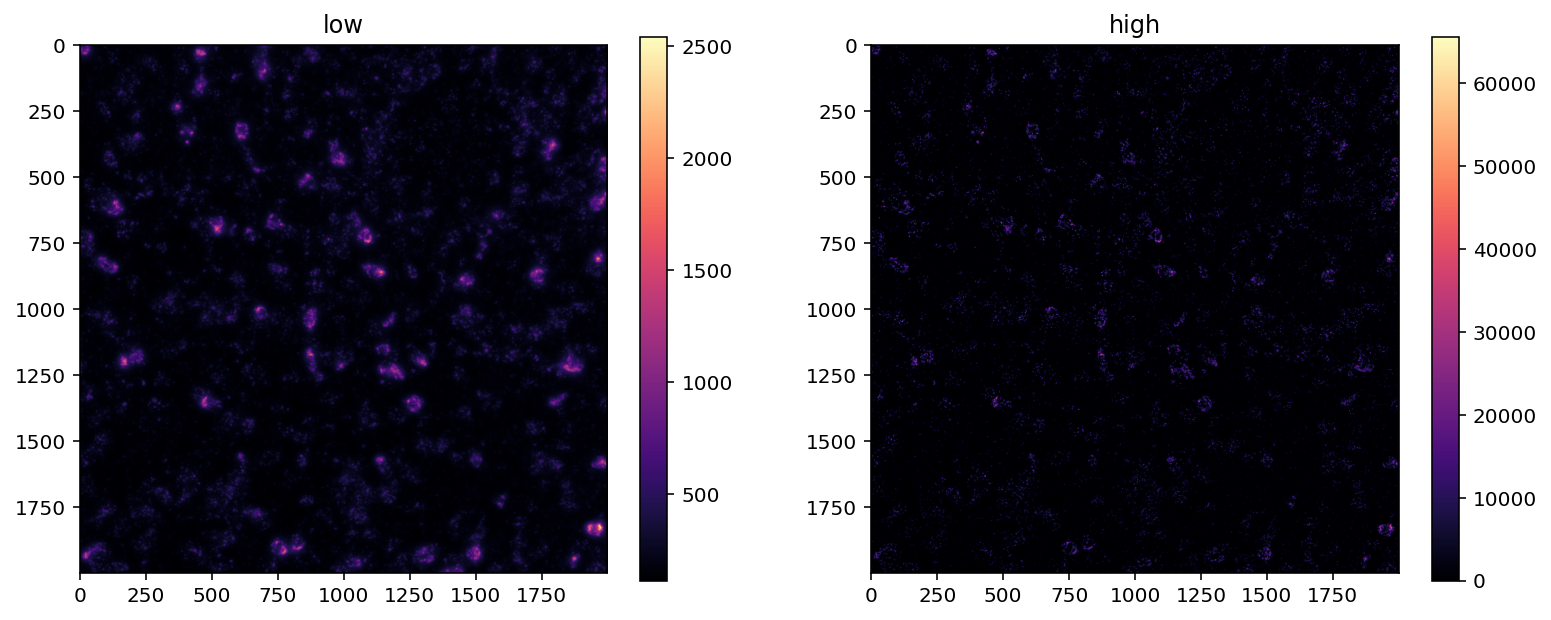

In [42]:
y = imread(r'T:\for_CARE\dw\primary-fov_010-c0-r0-z0.tiff')
x = imread('T:/for_CARE/binned2x2avg/primary-fov_010-c0-r0-z0.tiff')
print('image size =', x.shape)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.imshow(x, cmap  ="magma")
plt.colorbar()
plt.title("low")
plt.subplot(1,2,2)
plt.imshow(y, cmap  ="magma")
plt.colorbar()
plt.title("high");

<hr style="height:2px;">

# Generate training data for CARE

We first need to create a `RawData` object, which defines how to get the pairs of low/high SNR images and the semantics of each axis (e.g. which one is considered a color channel, etc.).

Here we have two folders "low" and "GT", where corresponding low and high-SNR TIFF images have identical filenames.  
For this case, we can simply use `RawData.from_folder` and set `axes = 'YX'` to indicate the semantic order of the image axes (i.e. we have typical 2 dimensional images). 

In [7]:
raw_data = RawData.from_folder (
    basepath    = 'N:/BROADMODELS/datamix/',
    source_dirs = ['binned2x2','non_dw'],
    target_dir  = 'dw',
    axes        = 'YX',
)

From corresponding images, the function `create_patches` will now generate lots of paired patches that will be used for training the CARE model later.

`create_patches` returns values `(X, Y, XY_axes)`.
By convention, the variable name `X` (or `x`) refers to an input variable for a machine learning model, whereas `Y` (or `y`) indicates an output variable.

As a general rule, use a *patch size* that is a power of two along all axes, or which is at least divisible by 8. For this example we will use patches of size 128x128.

An important aspect is *data normalization*, i.e. the rescaling of corresponding patches to a dynamic range of ~ (0,1). By default, this is automatically provided via percentile normalization, which can be adapted if needed. 

By default, patches are sampled from *non-background regions* i.e. that are above a relative threshold that can be given in the function below. We will disable this for this dataset as most image regions already contain foreground pixels and thus set the threshold to 0.

In [8]:
from csbdeep.data import no_background_patches, norm_percentiles, sample_percentiles

X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (128,128),
    patch_filter        = no_background_patches(0.3),
    n_patches_per_image = 128,#defalut 32
    save_file           = 'N:/BROADMODELS/datamix/train/datamix3NOV_binned_nondw_dw.npz',
)

 1984 raw images x    1 transformations   =  1984 images
 1984 images     x  128 patches per image = 253952 patches in total
Input data:
N:/BROADMODELS/datamix/: target='dw', sources=['binned2x2', 'non_dw'], axes='YX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
128 x 128


100%|██████████████████████████████████████████████████████████████████████████████| 1984/1984 [07:06<00:00,  4.65it/s]


Saving data to N:\BROADMODELS\datamix\train\datamix3NOV_binned_nondw_dw.npz.


In [5]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)

shape of X,Y = (126976, 1, 128, 128)
axes  of X,Y = SCYX


## Show some example patches

This shows some of the generated patch pairs (even rows: *input*, odd rows: *target*)

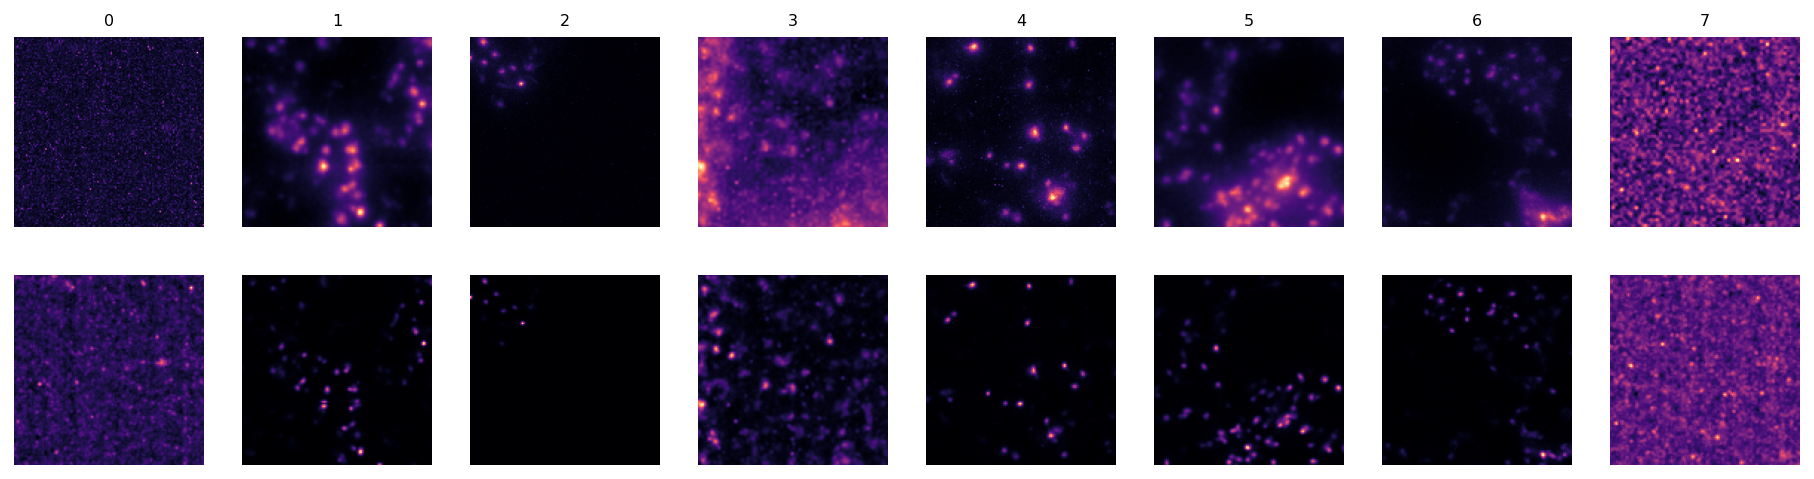

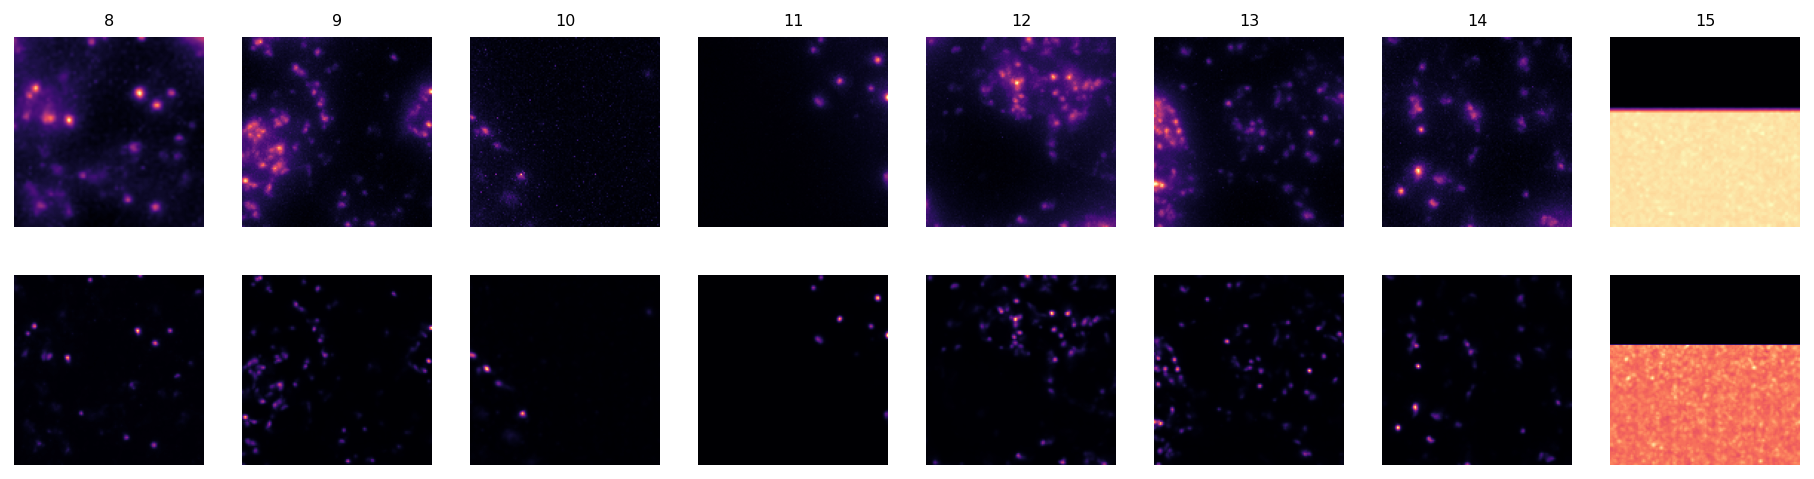

In [9]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;